In [1]:
import math
from math import pi
import time

import numpy as np
from matplotlib import pyplot as plt

import sigpy as sp
import sigpy.mri as spmri

from radial import trajectory

In [2]:
# Parameters and settings
device = 0
nx = 128
ncoils = 8

In [3]:
# Create phantom
phantom = sp.shepp_logan((nx, nx, nx), dtype=np.complex64)
print(f'phantom: {phantom.dtype}, {phantom.shape}')

phantom: complex64, (128, 128, 128)


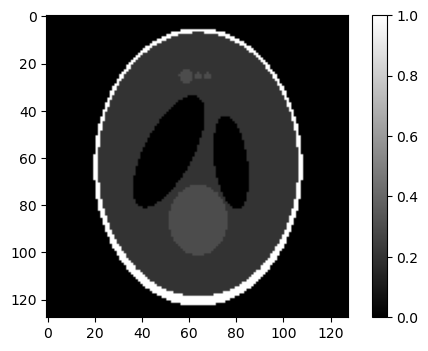

In [4]:
# Check phantom
f = plt.figure(dpi=100)
ax = f.subplots()
im = ax.imshow(np.abs(phantom[64, :, :]), cmap='gray')
f.colorbar(im)

In [5]:
# Generate coil maps
mps = spmri.birdcage_maps((ncoils, nx, nx, nx), dtype=np.complex64)
print(f'Coil sensitivity maps: {mps.dtype}, {mps.shape}')

Coil sensitivity maps: complex64, (8, 128, 128, 128)


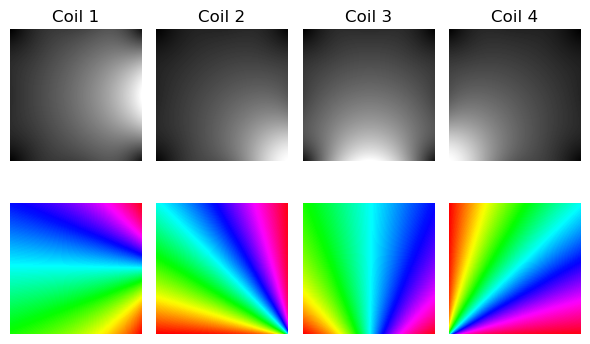

In [6]:
# Check maps
f = plt.figure(dpi=100)
axes = f.subplots(2, 4)
for _axes in axes:
    for ax in _axes:
        ax.set_axis_off()

axes[0, 0].set_title('Coil 1')
axes[0, 1].set_title('Coil 2')
axes[0, 2].set_title('Coil 3')
axes[0, 3].set_title('Coil 4')
axes[0, 0].imshow(np.abs(mps[0, 64, :, :]), cmap='gray')
axes[1, 0].imshow(np.angle(mps[0, 64, :, :]), cmap='hsv')
axes[0, 1].imshow(np.abs(mps[1, 64, :, :]), cmap='gray')
axes[1, 1].imshow(np.angle(mps[1, 64, :, :]), cmap='hsv')
axes[0, 2].imshow(np.abs(mps[2, 64, :, :]), cmap='gray')
axes[1, 2].imshow(np.angle(mps[2, 64, :, :]), cmap='hsv')
axes[0, 3].imshow(np.abs(mps[3, 64, :, :]), cmap='gray')
axes[1, 3].imshow(np.angle(mps[3, 64, :, :]), cmap='hsv')

plt.tight_layout()

In [7]:
# Create trajectory
traj = trajectory.unif_radial_3d(nx, num_theta=200)
na, ns, ndim = traj.shape
print(f'Trajectory: {traj.dtype}, {traj.shape}')
print(f'Min and Max: {traj.min()}, {traj.max()}')

Trajectory: float32, (25565, 128, 3)
Min and Max: -64.0, 64.0


In [8]:
print(f'For an image with size {nx}, and 3D k-space being sampled with full spokes, {math.ceil(4 * pi * (nx / 2) ** 2 / 2)} spokes are required to be fully sampled.')

For an image with size 128, and 3D k-space being sampled with full spokes, 25736 spokes are required to be fully sampled.


In [9]:
# Calculate density compensation
dcf = traj[..., 0] ** 2 + traj[..., 1] ** 2 + traj[..., 2] ** 2
print(f'Density compensation factor: {dcf.dtype}, {dcf.shape}')
# Normalize the DCF
# dcf /= np.sqrt(na)

Density compensation factor: float32, (25565, 128)


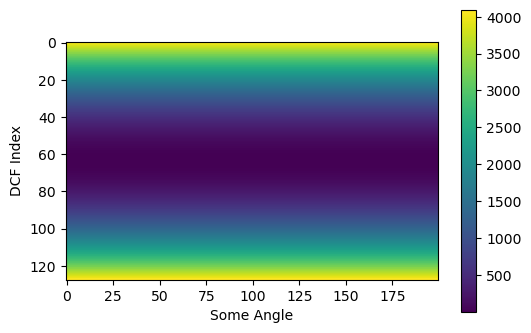

In [10]:
# Check density compensation
f = plt.figure(dpi=100)
ax = f.subplots()
im = ax.imshow(dcf[0:200].transpose())
ax.set_xlabel('Some Angle')
ax.set_ylabel('DCF Index')
f.colorbar(im)

Text(0.5, 1.0, 'Spoke 10')

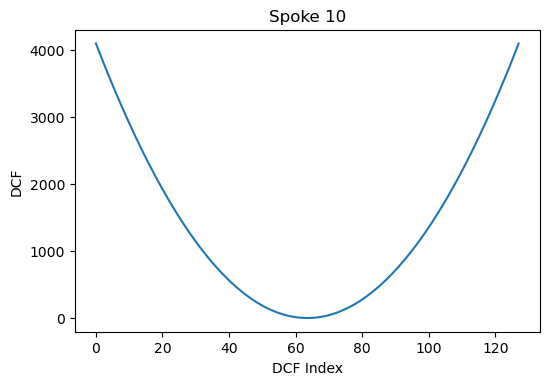

In [11]:
n = 10
f = plt.figure(dpi=100)
ax = f.subplots()
ax.plot(dcf[n])
ax.set_xlabel('DCF Index')
ax.set_ylabel('DCF')
ax.set_title(f'Spoke {n}')

In [12]:
# Move arrays to device
phantom = sp.to_device(phantom, device)
mps = sp.to_device(mps, device)
traj = sp.to_device(traj, device)
dcf = sp.to_device(dcf, device)
# Create linear operators
S = sp.linop.Multiply(phantom.shape, mps)
print(f'Shape of coil sensitivity operator: {S.oshape}, {S.ishape}')
F = sp.linop.NUFFT(S.oshape, traj)
print(f'Shape of Fourier operator: {F.oshape}, {F.ishape}')
D = sp.linop.Multiply((ncoils, na, ns), dcf)
print(f'Shape of density compensation weighting operator: {D.oshape}, {D.ishape}')

Shape of coil sensitivity operator: [8, 128, 128, 128], [128, 128, 128]
Shape of Fourier operator: [8, 25565, 128], [8, 128, 128, 128]
Shape of density compensation weighting operator: [8, 25565, 128], [8, 25565, 128]


In [13]:
# Simulate k-space
kspace = F * S * phantom
print(f'k-space: {kspace.dtype}, {kspace.shape}')

k-space: complex64, (8, 25565, 128)


In [14]:
# Reconstruct
img = S.H * F.H * D.H * kspace
print(f'Reconstructed image: {img.dtype}, {img.shape}')
img = sp.to_device(img)

Reconstructed image: complex64, (128, 128, 128)


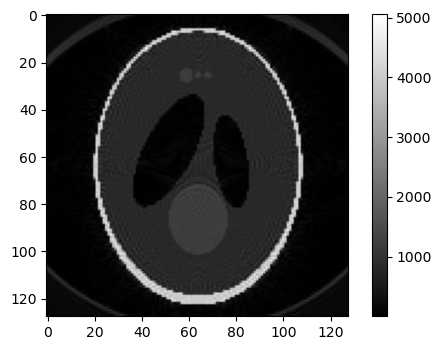

In [15]:
# Check image
f = plt.figure(dpi=100)
ax = f.subplots()
im = ax.imshow(np.abs(img[64, :, :]), cmap='gray')
f.colorbar(im)

Notice from the intensity of the image that the image is off by a factor, which is usually corrected by the DCF, but currently I'm not sure what that factor is.

Iterative reconstructions will reconstruct the correct intensity.

In [16]:
# Reconstruct with CG
# Compose linear operators
A = F * S
cg_app = sp.app.LinearLeastSquares(A, y=kspace)
print(f'The least squares solver is using the {cg_app.alg.__class__.__name__} algorithm.')
time.sleep(1)
img_sense = cg_app.run()
img_sense = sp.to_device(img_sense)
print(f'SENSE image: {img_sense.dtype}, {img_sense.shape}')

The least squares solver is using the ConjugateGradient algorithm.
LinearLeastSquares: 100%|██████████| 100/100 [03:53<00:00,  2.34s/it, resid=2.55E+02]SENSE image: complex64, (128, 128, 128)



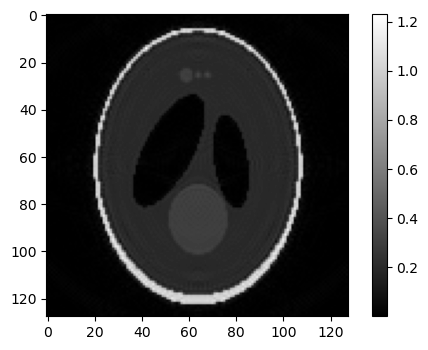

In [17]:
# Check image
f = plt.figure(dpi=100)
ax = f.subplots()
im = ax.imshow(np.abs(img_sense[64, :, :]), cmap='gray')
f.colorbar(im)